## Lab 6 (Image Processing using Convolutional Neural Networks)
- CIFAR10 dataset (see https://www.cs.toronto.edu/~kriz/cifar.html for more info)
- 60K images: 50K train, 10K test
- 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Perform multi-class classification with evaluation accuracy on EACH class

**CONNECT TO GPU** before continuing, but just CPU is also fine, it might be a bit slow.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Q1. Why are there 3 values in each list of the Normalize() function? What do they represent?
  ## The first chunk((0.5, 0.5, 0.5)) refers to each channel's means
  ## The second chunk((0.5, 0.5, 0.5)) refers to each channel's stadard diviations.
  ## By doing so, the value range has became [-1,1]

cuda
Files already downloaded and verified
Files already downloaded and verified


### Inspect the Images

In [ ]:
# Access the first data sample in the train_set using next(iter())
batch = next(iter(train_loader))
print(f'Image values: \n{batch}')
print(f'Length: {len(batch)}')
print(f'Type: {type(batch)}')

# This means the data contains image-label pairs
# Unpack them
images, labels = batch
# Same as these two lines:
# image = batch[0]
# label = batch[1]


print(images.shape)
print(labels)

# Q2. What is the range of the values for the normalised image pixels?
  ## [-1,1]

# Q3. What does each index value of the shape of the image represent?
  ## [4, 3, 32, 32] means the batch has 4 images, images are RGB scaled, an image consists of 32*32 pixels.

# Q4. What do the label values represent?
  ## label values [6, 4, 7, 3] refers to each image's class.

Image values: 
[tensor([[[[-0.9529, -0.8588, -0.8667,  ..., -0.9922, -0.9686, -0.9686],
          [-0.9765, -0.9294, -0.9216,  ..., -0.9922, -0.9843, -0.9686],
          [-0.9843, -1.0000, -0.9922,  ..., -0.9922, -0.9922, -0.9686],
          ...,
          [ 0.1059,  0.4510,  0.4588,  ..., -0.8275, -0.6078, -0.4039],
          [-0.1608,  0.2314,  0.4902,  ..., -0.7490, -0.4980, -0.6078],
          [-0.1294, -0.1608,  0.3333,  ..., -0.2706, -0.2000, -0.4196]],

         [[-0.9451, -0.8588, -0.8588,  ..., -0.9922, -0.9686, -0.9686],
          [-0.9686, -0.9294, -0.9216,  ..., -0.9922, -0.9843, -0.9686],
          [-0.9843, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9686],
          ...,
          [ 0.1451,  0.5686,  0.6471,  ..., -0.8039, -0.5608, -0.3490],
          [-0.1059,  0.3255,  0.6392,  ..., -0.6941, -0.4353, -0.5373],
          [-0.1294, -0.1373,  0.4196,  ..., -0.1843, -0.1216, -0.3412]],

         [[-0.9843, -0.8902, -0.8745,  ..., -0.9922, -0.9686, -0.9686],
          [-0.

### View some images
- Note that images have been normalised and may not look very clear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([6, 4, 7, 3])


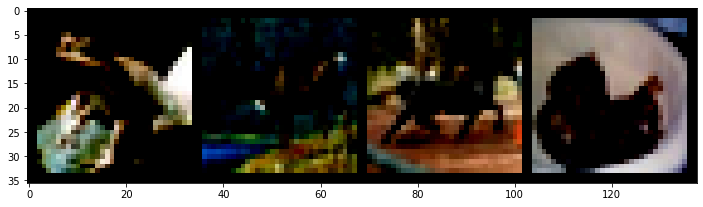

In [ ]:
# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

## CNN model

In [ ]:
class Test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(400, 128) # Q8. Fill out the correct input dimensions  -> 16*5*5
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    print(f'Input shape: {x.shape}')
    out = self.conv1(x)
    print(f'After Conv1: {out.shape}')
    print(f'Padding: {self.conv1.padding}')
    out = self.pool(F.relu(out))
    print(f'After Pool1: {out.shape}')
    out = self.conv2(out)
    print(f'After Conv2: {out.shape}')
    out = self.pool(F.relu(out))
    print(f'After Pool2: {out.shape}')
    # Flatten it before fc1
    out = out.reshape(-1, 400) # Q8. Fill out the correct dimension after -1
    print(f'Before fc1: {out.shape}')
    out = self.fc1(out)
    out = self.relu(out)
    print(f'After fc1: {out.shape}')
    out = self.fc2(out)
    out = self.relu(out)
    print(f'After fc2: {out.shape}')
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    print(f'After fc3: {out.shape}')
    return out


model = Test().to(device)
# Let's view the softmax output
probs = nn.Softmax(dim=1)


# Q5. What do the three arguments of the first convolutional layer, conv1 represent (3,6,5)? 
  ## The number of input channel is 3 / # of output channel is 6 / the kernel size is 5*5

# Q6. Explain the arguments of the second convolutional layer, conv2 (6, 16, 5) 
  ## The number of output channel of the image that came through (conv1 -> pool1) was 6.
  ## So the input channel size is 6 / we want to make the output channel size as 16 / and the kernel size is still same (5*5)

# Q7. Figure out the convolved image size after conv1
# Convolved image size = ((input_width - filter_size + 2 * padding) / stride) + 1
  ## ((32-5+2*0) / 1) + 1 = 28
  ## So the image size is 28*28

# Q8. Figure out the input size to the first fcn layer and fill out the code above in init() and forward()

### Run through a sample batch

In [ ]:
sample = next(iter(train_loader))

images, labels = sample

images = images.to(device)
labels = labels.to(device)

output = model(images)
print(f'Output shape: {output.shape}')
print(f'Softmax outputs:\n {probs(output)}')


# Q9. Explain the shape of the output after conv1
  ## The batch has 4 images / number of channel is 6 / the image size is 28*28

# Q10. What does the pooling do to the dimensions of the feature images here?
  ## It reduces the image size into half.

# Q11. Add padding=1 to conv1 and rerun the last two code cells. How did padding affect the dimensions of the feature images?
  ## It made the reduction of image size slower.
  ## By the way, the output size after poo2 was same as before.

# Q12. What is represented by each list returned by Softmax outputs?
  ## The 10 values of each list means the probablity of which class the image belongs to.
  ## Within 10 values, CNN model gives class to an image using the highest value(probability).

Input shape: torch.Size([4, 3, 32, 32])
After Conv1: torch.Size([4, 6, 30, 30])
Padding: (1, 1)
After Pool1: torch.Size([4, 6, 15, 15])
After Conv2: torch.Size([4, 16, 11, 11])
After Pool2: torch.Size([4, 16, 5, 5])
Before fc1: torch.Size([4, 400])
After fc1: torch.Size([4, 128])
After fc2: torch.Size([4, 64])
After fc3: torch.Size([4, 10])
Output shape: torch.Size([4, 10])
Softmax outputs:
 tensor([[0.0941, 0.1036, 0.1133, 0.0987, 0.1046, 0.0839, 0.0905, 0.0966, 0.1096,
         0.1051],
        [0.0920, 0.1038, 0.1138, 0.1012, 0.1045, 0.0844, 0.0911, 0.0945, 0.1087,
         0.1061],
        [0.0939, 0.1039, 0.1132, 0.0996, 0.1034, 0.0840, 0.0897, 0.0958, 0.1093,
         0.1072],
        [0.0938, 0.1038, 0.1134, 0.0998, 0.1055, 0.0836, 0.0901, 0.0951, 0.1092,
         0.1057]], device='cuda:0', grad_fn=<SoftmaxBackward>)



### Let's Train!
- Now that we know and understand how CNNs work, let's put everything together for CIFAR-10 dataset
  - Download the data in batches and normalisation with shuffling
  - Build a model with 2 CNN layers containing ReLU and pooling
  - Passing the feature images to 3 fully connected layers (FCNs) also containing RELU activation
  - The final layer has 10 units to reprsent the number of output classes
  - Use Binary Cross Entropy Loss and SGD optimiser
  - Evaluate the model on the test data on EACH class

**IMPORTANT!** Fill out the missing code below before training 

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(400, 256) # TODO
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 400) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))
    out = self.fc4(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss()

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Training loop

In [ ]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')



Epoch 1/5, Iteration 1000/12500, Loss=2.3326 
Epoch 1/5, Iteration 2000/12500, Loss=2.2623 
Epoch 1/5, Iteration 3000/12500, Loss=2.0769 
Epoch 1/5, Iteration 4000/12500, Loss=2.0251 
Epoch 1/5, Iteration 5000/12500, Loss=2.3518 
Epoch 1/5, Iteration 6000/12500, Loss=2.0192 
Epoch 1/5, Iteration 7000/12500, Loss=1.6025 
Epoch 1/5, Iteration 8000/12500, Loss=1.2004 
Epoch 1/5, Iteration 9000/12500, Loss=1.7578 
Epoch 1/5, Iteration 10000/12500, Loss=1.7630 
Epoch 1/5, Iteration 11000/12500, Loss=1.6056 
Epoch 1/5, Iteration 12000/12500, Loss=2.0629 
Epoch 2/5, Iteration 1000/12500, Loss=1.0972 
Epoch 2/5, Iteration 2000/12500, Loss=1.9703 
Epoch 2/5, Iteration 3000/12500, Loss=1.1913 
Epoch 2/5, Iteration 4000/12500, Loss=1.8386 
Epoch 2/5, Iteration 5000/12500, Loss=0.4736 
Epoch 2/5, Iteration 6000/12500, Loss=1.0031 
Epoch 2/5, Iteration 7000/12500, Loss=0.5412 
Epoch 2/5, Iteration 8000/12500, Loss=1.5522 
Epoch 2/5, Iteration 9000/12500, Loss=0.8261 
Epoch 2/5, Iteration 10000/1250

## Evaluation

In [ ]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 62.15 %
Accuracy of plane: 67.6 %
Accuracy of car: 80.2 %
Accuracy of bird: 33.0 %
Accuracy of cat: 49.1 %
Accuracy of deer: 71.2 %
Accuracy of dog: 47.2 %
Accuracy of frog: 70.9 %
Accuracy of horse: 61.1 %
Accuracy of ship: 75.1 %
Accuracy of truck: 66.1 %


In [ ]:
# Q15. Why don't we need to reshape the input images when training and testing?
  ## That's because the shape of train/test images are just fit to the input shape of first convolution layer... I guess.

# Q16. Try to improve the model performance, e.g. by increasing the epochs, changing batch size, adding convolutions, etc.
  ## Changes) num_epochs = 5 / added 1 fc layer
  ## The image below is accuracy of the previous model.

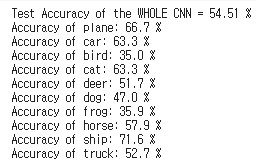